# Simple Example

In [1]:
import sys
sys.path.append('../../../notebooks')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

from raimitigations.utils import split_data, train_model_plot_results
from raimitigations.dataprocessing import (
    Rebalance,
    EncoderOrdinal,
    EncoderOHE,
    BasicImputer,
    SeqFeatSelection,
    CatBoostSelection,
    Synthesizer,
    Rebalance
)
from download import download_datasets

In [2]:
data_dir = '../../../datasets/'
download_datasets(data_dir)
dataset =  pd.read_csv(data_dir + 'hr_promotion/train.csv')
dataset.drop(columns=['employee_id'], inplace=True)
label_col = 'is_promoted'
dataset

department     region         education gender  \
0      Sales & Marketing   region_7  Master's & above      f   
1             Operations  region_22        Bachelor's      m   
2      Sales & Marketing  region_19        Bachelor's      m   
3      Sales & Marketing  region_23        Bachelor's      m   
4             Technology  region_26        Bachelor's      m   
...                  ...        ...               ...    ...   
54803         Technology  region_14        Bachelor's      m   
54804         Operations  region_27  Master's & above      f   
54805          Analytics   region_1        Bachelor's      m   
54806  Sales & Marketing   region_9               NaN      m   
54807                 HR  region_22        Bachelor's      m   

      recruitment_channel  no_of_trainings  age  previous_year_rating  \
0                sourcing                1   35                   5.0   
1                   other                1   30                   5.0   
2                sourcing                1   34                   3.0   
3                   other                2   39                   1.0   
4                   other                1   45                   3.0   
...                   ...              ...  ...                   ...   
54803            sourcing                1   48                   3.0   
54804               other                1   37                   2.0   
54805               other                1   27                   5.0   
54806            sourcing                1   29                   1.0   
54807               other                1   27                   1.0   

       length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                      8              1            0                  49   
1                      4              0            0                  60   
2                      7              0            0                  50   
3                     10              0            0                  50   
4                      2              0            0                  73   
...                  ...            ...          ...                 ...   
54803                 17              0            0                  78   
54804                  6              0            0                  56   
54805                  3              1            0                  79   
54806                  2              0            0                  45   
54807                  5              0            0                  49   

       is_promoted  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
54803            0  
54804            0  
54805            0  
54806            0  
54807            0  

[54808 rows x 13 columns]

## 1 - Base Model

Split the data into training and test sets.

In [3]:
train_x, test_x, train_y, test_y = split_data(dataset, label_col, test_size=0.2)
org_train_x = train_x.copy()
org_train_y = train_y.copy()
org_test_x = test_x.copy()
org_test_y = test_y.copy()
train_x

department     region         education gender  \
33758        Procurement   region_2        Bachelor's      f   
9792   Sales & Marketing  region_15               NaN      m   
30081         Technology  region_22  Master's & above      m   
50328              Legal   region_2  Master's & above      m   
13100         Operations   region_7        Bachelor's      f   
...                  ...        ...               ...    ...   
17487        Procurement  region_26        Bachelor's      f   
39779            Finance   region_8        Bachelor's      m   
13547          Analytics   region_7  Master's & above      m   
28716                R&D  region_11  Master's & above      m   
28553        Procurement  region_14  Master's & above      m   

      recruitment_channel  no_of_trainings  age  previous_year_rating  \
33758            sourcing                1   39                   3.0   
9792                other                1   32                   2.0   
30081            sourcing                4   33                   5.0   
50328            sourcing                2   35                   3.0   
13100               other                1   32                   4.0   
...                   ...              ...  ...                   ...   
17487               other                2   25                   3.0   
39779            sourcing                2   27                   4.0   
13547            sourcing                1   45                   3.0   
28716            sourcing                1   37                   4.0   
28553               other                1   37                   2.0   

       length_of_service  KPIs_met >80%  awards_won?  avg_training_score  
33758                 10              1            0                  68  
9792                   3              1            0                  48  
30081                  6              0            0                  77  
50328                  3              0            0                  60  
13100                  2              1            0                  60  
...                  ...            ...          ...                 ...  
17487                  3              0            0                  74  
39779                  2              1            0                  53  
13547                  3              1            0                  90  
28716                  3              0            0                  88  
28553                 10              0            0                  68  

[43846 rows x 12 columns]

Many models can't handle categorical data and missing values, so we cannot train the model just yet. First we need to encode all categorical data and remove missing values.

In [4]:
imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOrdinal(categories={'education': ["Below Secondary", "Bachelor's", "Master's & above"]})

imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

train_x

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']


department     region         education gender  \
33758        Procurement   region_2        Bachelor's      f   
9792   Sales & Marketing  region_15              NULL      m   
30081         Technology  region_22  Master's & above      m   
50328              Legal   region_2  Master's & above      m   
13100         Operations   region_7        Bachelor's      f   
...                  ...        ...               ...    ...   
17487        Procurement  region_26        Bachelor's      f   
39779            Finance   region_8        Bachelor's      m   
13547          Analytics   region_7  Master's & above      m   
28716                R&D  region_11  Master's & above      m   
28553        Procurement  region_14  Master's & above      m   

      recruitment_channel  no_of_trainings  age  previous_year_rating  \
33758            sourcing                1   39                   3.0   
9792                other                1   32                   2.0   
30081            sourcing                4   33                   5.0   
50328            sourcing                2   35                   3.0   
13100               other                1   32                   4.0   
...                   ...              ...  ...                   ...   
17487               other                2   25                   3.0   
39779            sourcing                2   27                   4.0   
13547            sourcing                1   45                   3.0   
28716            sourcing                1   37                   4.0   
28553               other                1   37                   2.0   

       length_of_service  KPIs_met >80%  awards_won?  avg_training_score  
33758                 10              1            0                  68  
9792                   3              1            0                  48  
30081                  6              0            0                  77  
50328                  3              0            0                  60  
13100                  2              1            0                  60  
...                  ...            ...          ...                 ...  
17487                  3              0            0                  74  
39779                  2              1            0                  53  
13547                  3              1            0                  90  
28716                  3              0            0                  88  
28553                 10              0            0                  68  

[43846 rows x 12 columns]

In [5]:
encoder.fit(train_x)
train_x = encoder.transform(train_x)
test_x = encoder.transform(test_x)
train_x

No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']


department  region  education  gender  recruitment_channel  \
33758           5      11          1       0                    2   
9792            7       6         -1       1                    0   
30081           8      14          2       1                    2   
50328           3      11          2       1                    2   
13100           4      31          1       0                    0   
...           ...     ...        ...     ...                  ...   
17487           5      18          1       0                    0   
39779           1      32          1       1                    2   
13547           0      31          2       1                    2   
28716           6       2          2       1                    2   
28553           5       5          2       1                    0   

       no_of_trainings  age  previous_year_rating  length_of_service  \
33758                1   39                   3.0                 10   
9792                 1   32                   2.0                  3   
30081                4   33                   5.0                  6   
50328                2   35                   3.0                  3   
13100                1   32                   4.0                  2   
...                ...  ...                   ...                ...   
17487                2   25                   3.0                  3   
39779                2   27                   4.0                  2   
13547                1   45                   3.0                  3   
28716                1   37                   4.0                  3   
28553                1   37                   2.0                 10   

       KPIs_met >80%  awards_won?  avg_training_score  
33758              1            0                  68  
9792               1            0                  48  
30081              0            0                  77  
50328              0            0                  60  
13100              1            0                  60  
...              ...          ...                 ...  
17487              0            0                  74  
39779              1            0                  53  
13547              1            0                  90  
28716              0            0                  88  
28553              0            0                  68  

[43846 rows x 12 columns]

 Now we create the model and train it using the training set. In the sequence, test its performance over the test set. 


TEST SET:



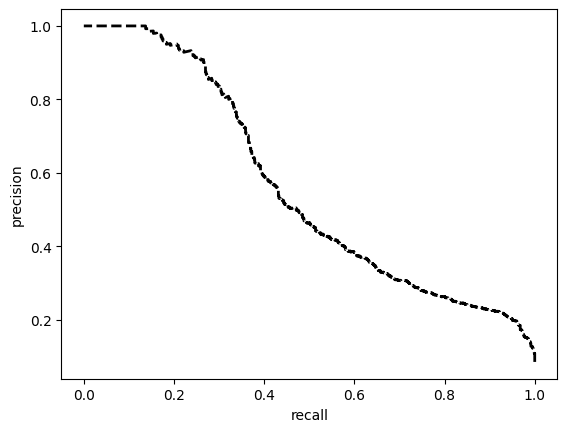

[[7042 2986]
 [  76  858]]


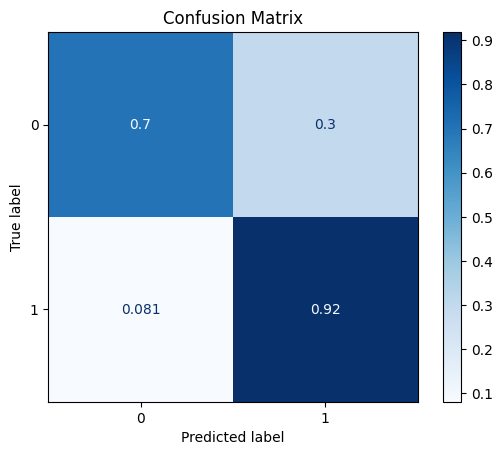

ROC AUC: 0.8931139490369151
Precision: 0.6062639191462251
Recall: 0.810431647916882
F1: 0.5902810799741827
Accuracy: 0.7206714103265828
Optimal Threshold (ROC curve): 0.11485043913125992
Optimal Threshold (Precision x Recall curve): 0.20340098440647125
Threshold used: 0.11485043913125992


In [6]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

## 2 - Feature Selection

In [7]:
from sklearn.neighbors import KNeighborsClassifier

feat_sel = SeqFeatSelection(scoring='f1', n_jobs=4)
feat_sel.fit(X=train_x, y=train_y)
feat_sel.get_selected_features()

No columns specified for imputation. These columns have been automatically identified:
[]
No columns specified for encoding. These columns have been automatically identfied as the following:
[]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.0s finished

[2022-10-25 10:12:26] Features: 1/12 -- score: 0.1931912046382492[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    0.2s finished

[2022-10-25 10:12:26] Features: 2/12 -- score: 0.4967097422285698[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished

[2022-10-25 10:12:26] Features: 3/12 -- score: 0.5026668595847746[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.3s finished

[2022-10-25 10:12:27] Features: 4/12 -- score: 0.499143998947

['department', 'awards_won?', 'avg_training_score']

In [8]:
train_x = feat_sel.transform(train_x)
test_x = feat_sel.transform(test_x)
train_x

department  awards_won?  avg_training_score
33758           5            0                  68
9792            7            0                  48
30081           8            0                  77
50328           3            0                  60
13100           4            0                  60
...           ...          ...                 ...
17487           5            0                  74
39779           1            0                  53
13547           0            0                  90
28716           6            0                  88
28553           5            0                  68

[43846 rows x 3 columns]


TEST SET:



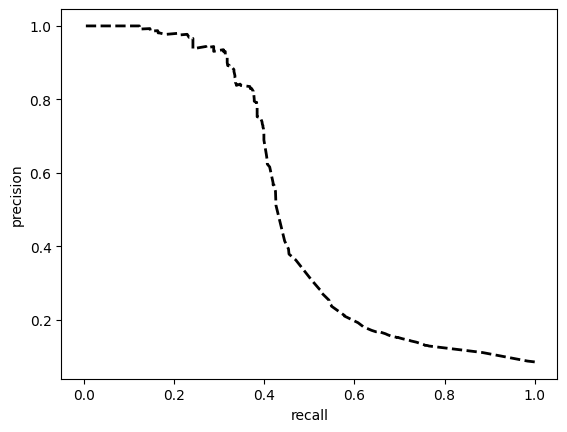

[[8756 1272]
 [ 442  492]]


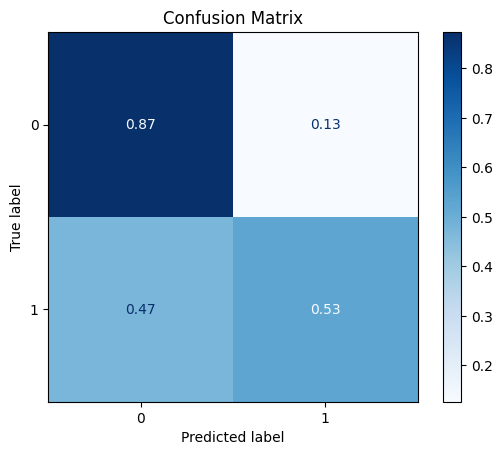

ROC AUC: 0.7554767422096075
Precision: 0.6154288199297984
Recall: 0.6999608804127886
F1: 0.6377822470914225
Accuracy: 0.8436416712278781
Optimal Threshold (ROC curve): 0.10499062389135361
Optimal Threshold (Precision x Recall curve): 0.2508904039859772
Threshold used: 0.10499062389135361


In [9]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

## 3 - Generating Synthetic Data + Feature Selection

In [10]:
dataset[label_col].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [11]:
train_df = org_train_x.copy()
train_df[label_col] = org_train_y
test_x = org_test_x
test_y = org_test_y

train_df[label_col].value_counts(normalize=True)

0    0.914838
1    0.085162
Name: is_promoted, dtype: float64

In [12]:
synth = Synthesizer(
				df=train_df,
				label_col=label_col,
				model='ctgan',
				epochs=150,
				load_existing=False
			)
balance_train = synth.fit_resample(df=train_df, label_col=label_col, strategy=0.3)
balance_train[label_col].value_counts(normalize=True)

/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:131: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  cluster.KMeans(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/math

0    0.76924
1    0.23076
Name: is_promoted, dtype: float64

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']
No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']

TEST SET:



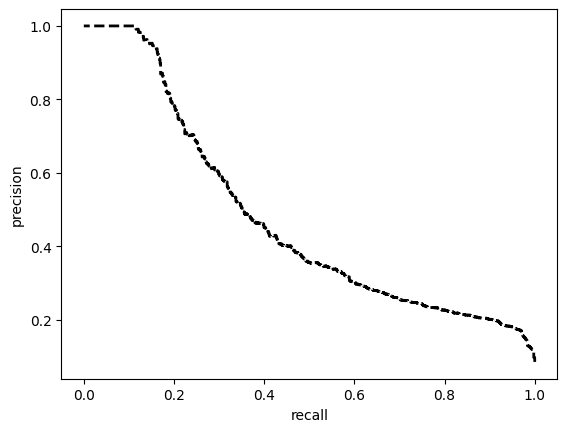

[[6623 3405]
 [  84  850]]


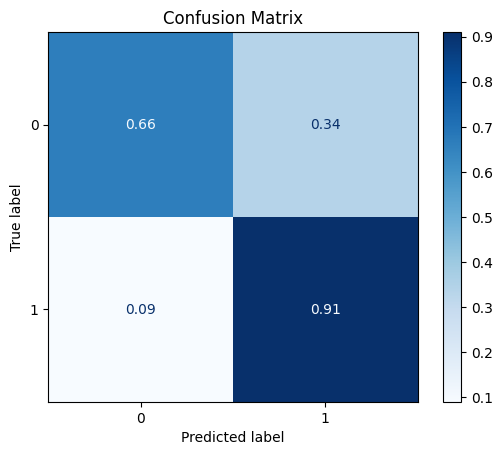

ROC AUC: 0.8670331743495088
Precision: 0.5936203769778037
Recall: 0.7852574888812396
F1: 0.5595654501838281
Accuracy: 0.6817186644772851
Optimal Threshold (ROC curve): 0.21035872399806976
Optimal Threshold (Precision x Recall curve): 0.39564475417137146
Threshold used: 0.21035872399806976


In [13]:
train_x = balance_train.drop(columns=[label_col])
train_y = balance_train[label_col]

imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOrdinal(categories={'education': ["Below Secondary", "Bachelor's", "Master's & above"]})

imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

encoder.fit(train_x)
train_x = encoder.transform(train_x)
test_x = encoder.transform(test_x)

model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

No columns specified for imputation. These columns have been automatically identified:
[]
No columns specified for encoding. These columns have been automatically identfied as the following:
[]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    0.9s finished

[2022-10-25 10:17:47] Features: 1/12 -- score: 0.20592887926502257[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    0.1s finished

[2022-10-25 10:17:48] Features: 2/12 -- score: 0.2639678881869736[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished

[2022-10-25 10:17:48] Features: 3/12 -- score: 0.4590688345129712[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.2s finished

[2022-10-25 10:17:48] Features: 4/12 -- score: 0.45757177159

SELECTED FEATURES: ['department', 'awards_won?', 'avg_training_score']

TEST SET:



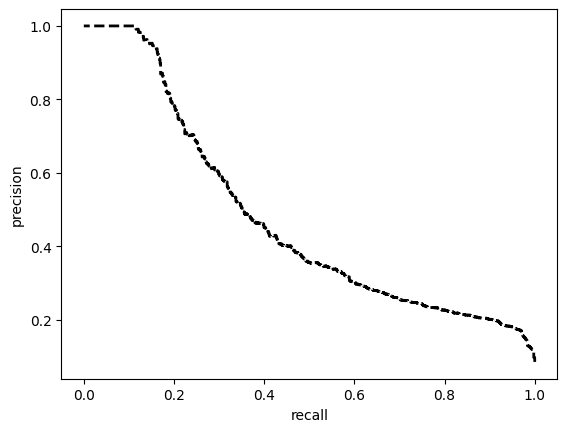

[[6623 3405]
 [  84  850]]


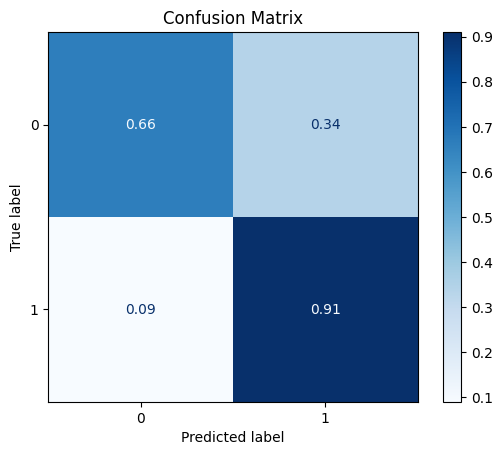

ROC AUC: 0.8670331743495088
Precision: 0.5936203769778037
Recall: 0.7852574888812396
F1: 0.5595654501838281
Accuracy: 0.6817186644772851
Optimal Threshold (ROC curve): 0.21035872399806976
Optimal Threshold (Precision x Recall curve): 0.39564475417137146
Threshold used: 0.21035872399806976


In [14]:
feat_sel = SeqFeatSelection(scoring='f1', n_jobs=4)
feat_sel.fit(X=train_x, y=train_y)
print(f"SELECTED FEATURES: {feat_sel.get_selected_features()}")
train_x_feat = feat_sel.transform(train_x)
test_x_feat = feat_sel.transform(test_x)
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

## 4 - Feature Selection + Synthetic Data

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']
No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']
SELECTED FEATURES: ['awards_won?', 'avg_training_score', 'department_Finance', 'department_HR', 'department_Legal', 'department_Operations', 'department_Procurement', 'department_Sales & Marketing', 'department_Technology', "education_Master's & above"]

TEST SET:



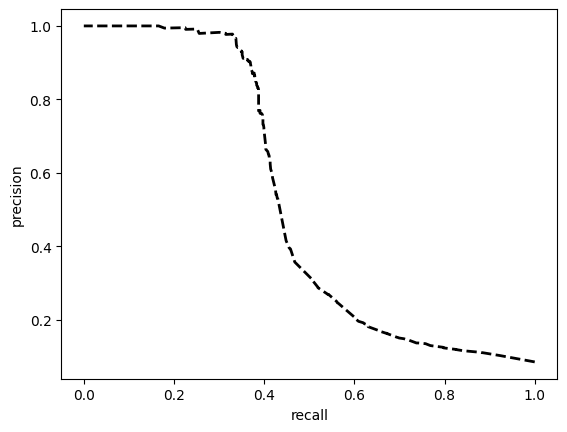

[[8639 1389]
 [ 426  508]]


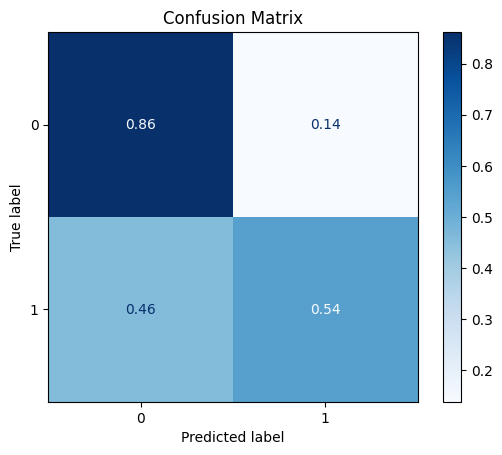

ROC AUC: 0.7596129659223981
Precision: 0.6103986583164233
Recall: 0.7026925251693545
F1: 0.631911384760566
Accuracy: 0.8344280240831965
Optimal Threshold (ROC curve): 0.10077095776796341
Optimal Threshold (Precision x Recall curve): 0.2247779816389084
Threshold used: 0.10077095776796341


In [15]:
train_x = org_train_x
train_y = org_train_y
test_x = org_test_x
test_y = org_test_y

imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOHE()

feat_sel = SeqFeatSelection(scoring='f1', transform_pipe=[imputer, encoder], n_jobs=4, verbose=False)
feat_sel.fit(X=train_x, y=train_y)
print(f"SELECTED FEATURES: {feat_sel.get_selected_features()}")

train_x = feat_sel.transform(train_x)
test_x = feat_sel.transform(test_x)

model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)

In [16]:
train_df = train_x
train_df[label_col] = train_y
test_df = test_x
test_df[label_col] = test_y

synth = Synthesizer(
				df=train_df,
				label_col=label_col,
				model='ctgan',
				epochs=130,
				load_existing=False
			)
balance_train = synth.fit_resample(df=train_df, label_col=label_col, strategy=0.3)
balance_train[label_col].value_counts(normalize=True)

/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/ctgan/data_transformer.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()
Sampling conditions:   0%|          | 0/8299 [00:00<?, ?it/s]/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sdv/tabular/base.py:608: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't

0    0.76924
1    0.23076
Name: is_promoted, dtype: float64


TEST SET:



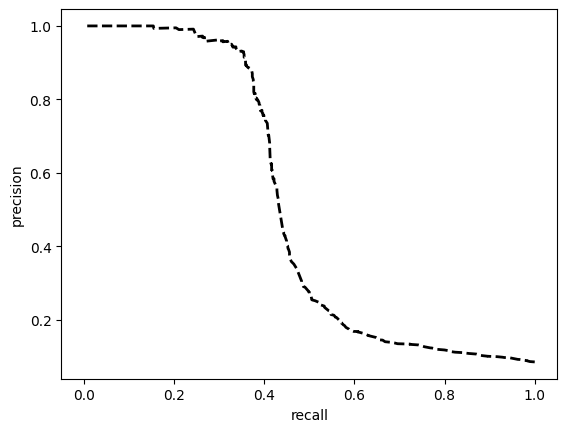

[[9712  316]
 [ 534  400]]


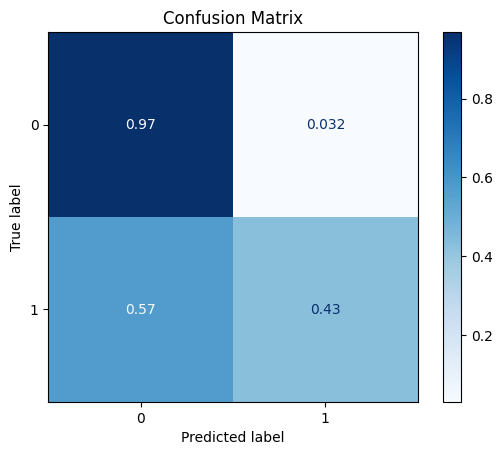

ROC AUC: 0.7403760370320707
Precision: 0.7532706591044659
Recall: 0.698376878786507
F1: 0.7214614329145256
Accuracy: 0.9224594052180259
Optimal Threshold (ROC curve): 0.35927507281303406
Optimal Threshold (Precision x Recall curve): 0.4259410798549652
Threshold used: 0.35927507281303406


In [17]:
train_x = balance_train.drop(columns=[label_col])
train_y = balance_train[label_col]
test_x = test_df.drop(columns=[label_col])
test_y = test_df[label_col]

model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False)